Function to fetch the data from https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.tgz.
It creates a <i>dataset/housing</i> directory in your workspace, downloads the <i>housing.tgz</i> file, and extracts the <i>housing.csv</i> from it in this directory.

In [1]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

fetch_housing_data(HOUSING_URL, HOUSING_PATH)

Load the data using Pandas. Returns a Pandas DataFrame object containing all the data.

In [2]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

Show the first 5 rows.

In [3]:
housing = load_housing_data()
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

The <code>info()</code> method is useful to get a quick description of the data, in particular the total number of rows, and each attribute’s type and number of non-null values.

In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


<code>ocean_proximity</code> is an object type. We can see it's a categorical attribute and we can find out its categories:

In [5]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

<code>describe()</code> shows a summary of the numerical attributes.

In [6]:
housing.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

Histograms show the number of instances (on the vertical axis) that have a given value range (on the horizontal axis). You can either plot this one attribute at a time, or you can call the hist() method on the whole dataset, and it will plot a histogram for each numerical attribute. For example, you can see that slightly over 800 districts have a median_house_value equal to about $500,000.
<code>%matplotlib</code> inline can be used only in jupyter notebooks.

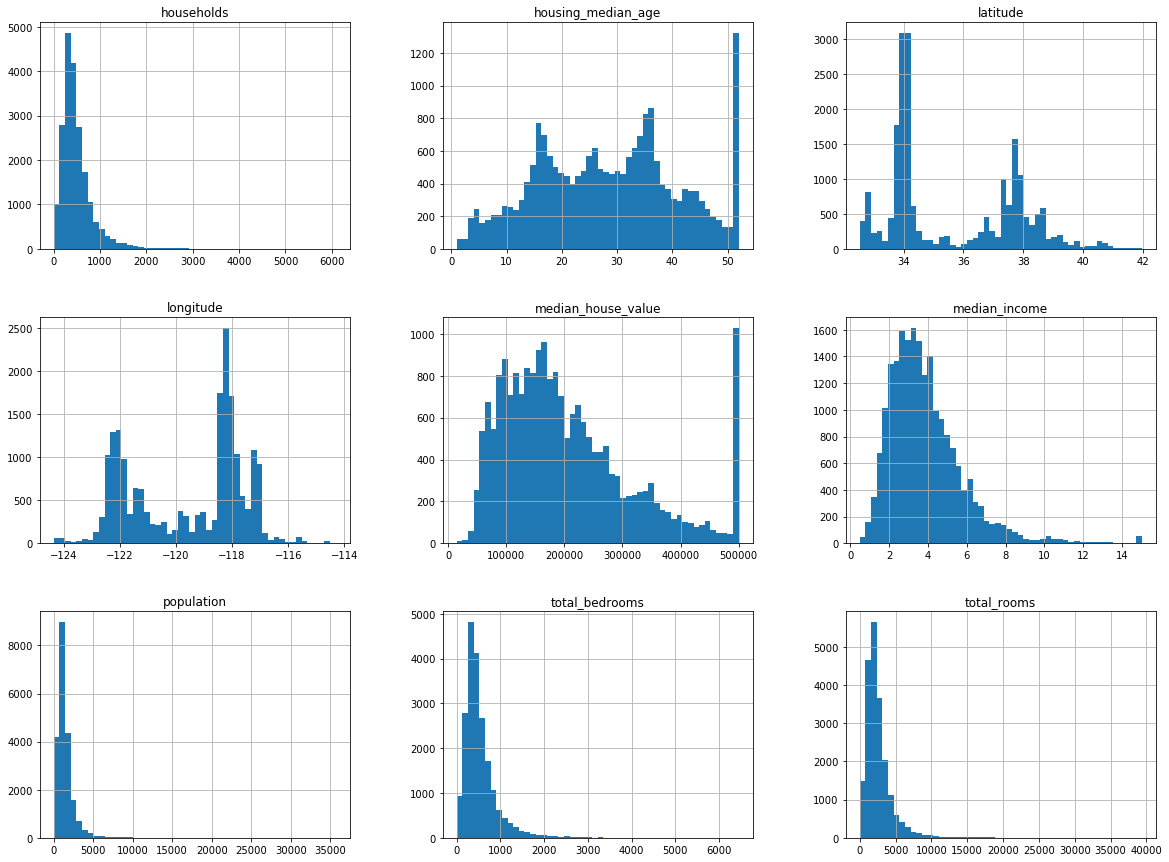

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

## Test Set

To create a Test Set we need to separate 20% of the dataset and put it away. To create this test set without it breaking every time we fetch an updated dataset a common solution is to use each instance’s identifier to decide whether or not it should go in the test set (assuming instances have a unique and immutable identifier). 

For example, we could compute a hash of each instance’s identifier, keep only the last byte of the hash, and put the instance in the test set if this value is lower or equal to 51 (~20% of 256). This ensures that the test set will remain consistent across multiple runs, even if you refresh the dataset. The new test set will contain 20% of the new instances, but it will not contain any instance that was previously in the training set. Here is a possible implementation:

In [8]:
import hashlib
import numpy as np

def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

The housing dataset does not have an identifier column, so we could use the row index as the ID (new entries in the dataset must be appended):

In [9]:
housing_with_id = housing.reset_index() # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")
test_set.head()

index  longitude  latitude  housing_median_age  total_rooms  \
4       4    -122.25     37.85                52.0       1627.0   
5       5    -122.25     37.85                52.0        919.0   
11     11    -122.26     37.85                52.0       3503.0   
20     20    -122.27     37.85                40.0        751.0   
23     23    -122.27     37.84                52.0       1688.0   

    total_bedrooms  population  households  median_income  median_house_value  \
4            280.0       565.0       259.0         3.8462            342200.0   
5            213.0       413.0       193.0         4.0368            269700.0   
11           752.0      1504.0       734.0         3.2705            241800.0   
20           184.0       409.0       166.0         1.3578            147500.0   
23           337.0       853.0       325.0         2.1806             99700.0   

   ocean_proximity  
4         NEAR BAY  
5         NEAR BAY  
11        NEAR BAY  
20        NEAR BAY  
23        NEAR BAY

If this is not possible, then you can try to use the most stable features to build a unique identifier. For example, a district’s latitude and longitude are guaranteed to be stable for a few million years, so you could combine them into an ID like so:

In [10]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")
test_set.head()

index  longitude  latitude  housing_median_age  total_rooms  \
8       8    -122.26     37.84                42.0       2555.0   
10     10    -122.26     37.85                52.0       2202.0   
11     11    -122.26     37.85                52.0       3503.0   
12     12    -122.26     37.85                52.0       2491.0   
13     13    -122.26     37.84                52.0        696.0   

    total_bedrooms  population  households  median_income  median_house_value  \
8            665.0      1206.0       595.0         2.0804            226700.0   
10           434.0       910.0       402.0         3.2031            281500.0   
11           752.0      1504.0       734.0         3.2705            241800.0   
12           474.0      1098.0       468.0         3.0750            213500.0   
13           191.0       345.0       174.0         2.6736            191300.0   

   ocean_proximity         id  
8         NEAR BAY -122222.16  
10        NEAR BAY -122222.15  
11        NEAR BAY -122222.15  
12        NEAR BAY -122222.15  
13        NEAR BAY -122222.16

Scikit-Learn provides a few functions to split datasets into multiple subsets in various ways. The simplest function is train_test_split. 
First there is a random_state parameter that allows you to set the random generator seed, and second you can pass it multiple datasets with an identical number of rows, and it will split them on the same indices (this is very useful, for example, if you have a separate DataFrame for labels):

In [11]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
test_set.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
20046    -119.01     36.06                25.0       1505.0             NaN   
3024     -119.46     35.14                30.0       2943.0             NaN   
15663    -122.44     37.80                52.0       3830.0             NaN   
20484    -118.72     34.28                17.0       3051.0             NaN   
9814     -121.93     36.62                34.0       2351.0             NaN   

       population  households  median_income  median_house_value  \
20046      1392.0       359.0         1.6812             47700.0   
3024       1565.0       584.0         2.5313             45800.0   
15663      1310.0       963.0         3.4801            500001.0   
20484      1705.0       495.0         5.7376            218600.0   
9814       1063.0       428.0         3.7250            278000.0   

      ocean_proximity  
20046          INLAND  
3024           INLAND  
15663        NEAR BAY  
20484       <1H OCEAN  
9814       NEAR OCEAN

So far we have considered purely random sampling methods. This is generally fine if your dataset is large enough (especially relative to the number of attributes), but if it is not, you run the risk of introducing a significant sampling bias.
We should an approach called <i>stratified sampling</i>: the population is divided into homogeneous subgroups called strata, and the right number of instances is sampled from each stratum to guarantee that the test set is representative of the overall population. 

Suppose that the median income is a very important attribute to predict median housing prices. You may want to ensure that the test set is representative of the various categories of incomes in the whole dataset.

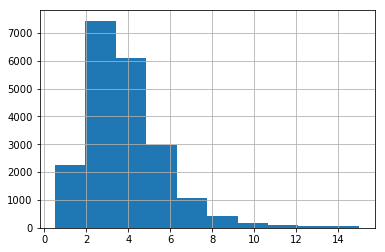

In [12]:
housing["median_income"].hist()

Since the median income is a continuous numerical attribute, you first need to create an income category attribute.

Most median income values are clustered around 2–5 (tens of thousands of dollars), but some median incomes go far beyond 6. It is important to have a sufficient number of instances in your dataset for each stratum, or else the estimate of the stratum’s importance may be biased. This means that you should not have too many strata, and each stratum should be large enough.

The following code creates an income category attribute by dividing the median income by 1.5 (to limit the number of income categories), and rounding up using ceil (to have discrete categories), and then merging all the categories greater than 5 into category 5:

In [13]:
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)
housing["income_cat"].value_counts()

3.0    7236
2.0    6581
4.0    3639
5.0    2362
1.0     822
Name: income_cat, dtype: int64

Now you are ready to do stratified sampling based on the income category. For this you can use Scikit-Learn’s <code>StratifiedShuffleSplit</code> class:

In [14]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

Incoming proportions inside the 2 separeted datasets:

In [15]:
strat_train_set["income_cat"].value_counts() / len(housing)

3.0    0.280475
2.0    0.255087
4.0    0.141037
5.0    0.091521
1.0    0.031880
Name: income_cat, dtype: float64

In [16]:
strat_test_set["income_cat"].value_counts() / len(housing)

3.0    0.070107
2.0    0.063760
4.0    0.035271
5.0    0.022917
1.0    0.007946
Name: income_cat, dtype: float64

Now you should remove the <code>income_cat</code> attribute so the data is back to its original state:


In [17]:
for set in (strat_train_set, strat_test_set):
    set.drop(["income_cat"], axis=1, inplace=True)

# Discover and Visualize the Data to Gain Insights

If the training set is very large, you may want to sample an exploration set, to make manipulations easy and fast. In our case, the set is quite small so you can just work directly on the full set. Let’s create a copy so you can play with it without harming the training set:

In [18]:
housing = strat_train_set.copy()

Geographical scatterplot of the districts:

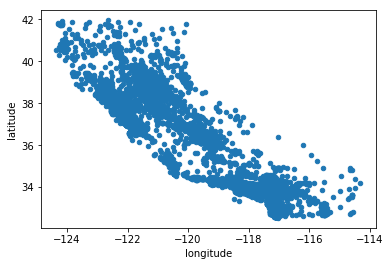

In [19]:
housing.plot(kind="scatter", x="longitude", y="latitude")

Setting the alpha option to 0.1 makes it much easier to visualize the places where there is a high density of data points:

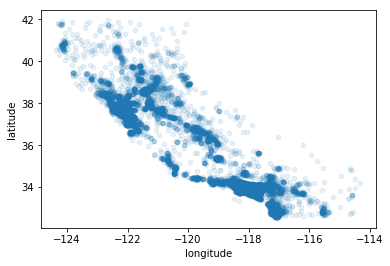

In [20]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

Scatter plot of the housing prices: the radius of each circle represents the district’s population (option <code>s</code>), and the color represents the price (option <code>c</code>). We will use a predefined color map (option <code>cmap</code>) called <code>jet</code>, which ranges from blue (low values) to red (high prices):

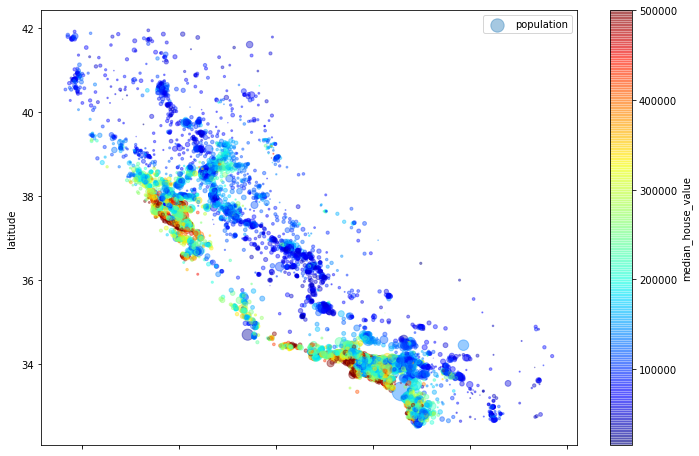

In [21]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population",
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True, figsize=(12,8),
)
plt.legend()

This image tells you that the housing prices are very much related to the location (e.g., close to the ocean) and to the population density, as you probably knew already. It will probably be useful to use a clustering algorithm to detect the main clusters, and add new features that measure the proximity to the cluster centers. The ocean proximity attribute may be useful as well, although in Northern California the housing prices in coastal districts are not too high, so it is not a simple rule.

Since the dataset is not too large, you can easily compute the <i>standard correlation coefficient</i> (also called Pearson’s <i>r</i>) between every pair of attributes:

In [22]:
corr_matrix = housing.corr()

Now let’s look at how much each attribute correlates with the median house value:

In [23]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

The correlation coefficient ranges from –1 to 1. When it is close to 1, it means that there is a strong positive correlation; for example, the median house value tends to go up when the median income goes up. When the coefficient is close to –1, it means that there is a strong negative correlation; you can see a small negative correlation between the latitude and the median house value (i.e., prices have a slight tendency to go down when you go north). Finally, coefficients close to zero mean that there is no linear correlation.

The correlation coefficient only measures linear correlations (“if x goes up, then y generally goes up/down”). It may completely miss out on nonlinear relationships (e.g., “if x is close to zero then y generally goes up”).

Another way to check for correlation between attributes is to use Pandas&rsquo; <tt>scatter_matrix</tt> function, which plots every numerical attribute against every other numerical attribute. Since there are now 11 numerical attributes, you would get 11<sup>2</sup> = 121 plots, which would not fit on a page, so let&rsquo;s just focus on a few promising attributes that seem most correlated with the median housing value:


In [26]:
from pandas.tools.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(20, 14))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11d090080>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11d56e748>]], dtype=object)

The most promising attribute to predict the median house value is the median income, so let’s zoom in on their correlation scatterplot

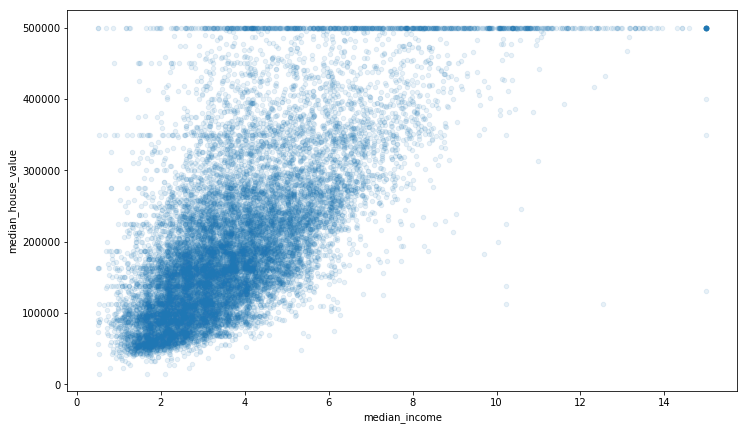

In [29]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", figsize=(12,7),
             alpha=0.1)

This plot reveals a few things. First, the correlation is indeed very strong; you can clearly see the upward trend and the points are not too dispersed. Second, the price cap that we noticed earlier is clearly visible as a horizontal line at \\$500,000. But this plot reveals other less obvious straight lines: a horizontal line around \\$450,000, another around \\$350,000, perhaps one around $280,000, and a few more below that. You may want to try removing the corresponding districts to prevent your algorithms from learning to reproduce these data quirks.

### Experimenting with Attribute Combinations

One last thing you may want to do before actually preparing the data for Machine Learning algorithms is to try out various attribute combinations. 
For example, the total number of rooms in a district is not very useful if you don’t know how many households there are. What you really want is the number of rooms per household. Similarly, the total number of bedrooms by itself is not very useful: you probably want to compare it to the number of rooms. And the population per household also seems like an interesting attribute combination to look at. Let’s create these new attributes:

In [30]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [31]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

<p>The new <tt>bedrooms_per_room</tt> attribute is much more correlated with the median house value than the total number of rooms or bedrooms. Apparently houses with a lower bedroom/room ratio tend to be more expensive. The number of rooms per household is also more informative than the total number of rooms in a district&mdash;obviously the larger the houses, the more expensive they are.</p>


# Prepare the Data for Machine Learning Algorithms

<p>It&rsquo;s&nbsp;time to prepare the data for your Machine Learning algorithms. Instead of just doing this manually, you should write functions to do that, for several good reasons:</p>

<ul>
	<li>
	<p>This will allow you to reproduce these transformations easily on any dataset (e.g., the next time you get a fresh dataset).</p>
	</li>
	<li>
	<p>You will gradually build a library of transformation functions that you can reuse in future projects.</p>
	</li>
	<li>
	<p>You can use these functions in your live system to transform the new data before feeding it to your algorithms.</p>
	</li>
	<li>
	<p>This will make it possible for you to easily try various transformations and see which combination of transformations works best.</p>
	</li>
</ul>

<p>But first let&rsquo;s revert to a clean&nbsp;training set (by copying&nbsp;<code>strat_train_set</code>&nbsp;once again), and let&rsquo;s separate the predictors and the labels since we don&rsquo;t necessarily want to apply the same transformations to the predictors and the target values (note that&nbsp;<code>drop()</code>&nbsp;creates a copy of the data and does not affect&nbsp;<code>strat_train_set</code>):</p>


In [32]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

### Data Cleaning

<p>Most&nbsp;Machine Learning algorithms cannot work with missing features, so let&rsquo;s create a few functions to take care of them.&nbsp;<code>total_bedrooms</code>&nbsp;attribute has some missing values, so let&rsquo;s fix this. You have three options:</p>

<ul>
	<li>
	<p>Get rid of the corresponding districts.</p>
	</li>
	<li>
	<p>Get rid of the whole attribute.</p>
	</li>
	<li>
	<p>Set the values to some value (zero, the mean, the median, etc.).</p>
	</li>
</ul>

<p>You can accomplish these easily using&nbsp;DataFrame&rsquo;s&nbsp;<code>dropna()</code>,&nbsp;<code>drop()</code>,&nbsp;and&nbsp;<code>fillna()</code>&nbsp;methods:</p>

<div style="background:#eee; border:1px solid #ccc; padding:5px 10px"><tt>housing.dropna(subset=[&quot;total_bedrooms&quot;]) &nbsp; &nbsp;# option 1<br />
housing.drop(&quot;total_bedrooms&quot;, axis=1) &nbsp; &nbsp; &nbsp; # option 2<br />
median = housing[&quot;total_bedrooms&quot;].median()<br />
housing[&quot;total_bedrooms&quot;].fillna(median) &nbsp; &nbsp; # option 3</tt></div>


<p>Scikit-Learn&nbsp;provides a handy class to take care of missing values:&nbsp;<code>Imputer</code>. Here is how to use it. First, you need to create an&nbsp;<code>Imputer</code>&nbsp;instance, specifying that you want to replace each attribute&rsquo;s missing values with the median of that attribute:</p>


In [33]:
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy="median")

Since the median can only be computed on numerical attributes, we need to create a copy of the data without the text attribute ocean_proximity:

In [35]:
housing_num = housing.drop("ocean_proximity", axis=1)

Now you can fit the imputer instance to the training data using the fit() method:

In [36]:
imputer.fit(housing_num)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

<p>The&nbsp;<code>imputer</code>&nbsp;has simply computed the median of each attribute and stored the result in its&nbsp;<code>statistics_</code>&nbsp;instance variable. Only the&nbsp;<code>total_bedrooms</code>&nbsp;attribute had missing values, but we cannot be sure that there won&rsquo;t be any missing values in new data after the system goes live, so it is safer to apply the&nbsp;<code>imputer</code>&nbsp;to all the numerical attributes:</p>


In [37]:
imputer.statistics_

array([ -118.51  ,    34.26  ,    29.    ,  2119.5   ,   433.    ,
        1164.    ,   408.    ,     3.5409])

In [38]:
housing_num.median().values

array([ -118.51  ,    34.26  ,    29.    ,  2119.5   ,   433.    ,
        1164.    ,   408.    ,     3.5409])

<p>Now you can use this &ldquo;trained&rdquo;&nbsp;<code>imputer</code>&nbsp;to transform the training set by replacing missing values by the learned medians:</p>


In [39]:
X = imputer.transform(housing_num)

The result is a plain Numpy array containing the transformed features. If you want to put it back into a Pandas DataFrame, it’s simple:

In [40]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns)